# Road Segment Length Distribution Check

In considering the algorithm to use for finding the nearest line segment to a point, I wondered what the longest road segments on the network were.

In [2]:
import pandas as pd
import numpy as np
import requests
from arcgis2geojson import arcgis2geojson
import json
import os
import math

DATA_SOURCE_URL = "https://mrgis.mainroads.wa.gov.au/arcgis/rest/services/OpenData/RoadAssets_DataPortal/MapServer/17/query?where=1%3D1&outFields=ROAD,START_SLK,END_SLK,CWY,NETWORK_TYPE,START_TRUE_DIST,END_TRUE_DIST&outSR=4326&f=json"

def download_fresh_data_as_json(url=DATA_SOURCE_URL, chunk_limit=None):

    response = requests.request("GET", f"{url}&returnCountOnly=true")
    record_count = response.json()["count"]

    print(f"Downloading from {record_count} records" + (":" if chunk_limit is None else f", {chunk_limit=}:"))
    print("." * math.floor(record_count/1000))

    output=[]
    offset = 0
    chunk_counter = 0
    while True:
        if chunk_limit is not None and chunk_counter >= chunk_limit:
            break
        chunk_counter += 1

        response = requests.request("GET", f"{url}&resultOffset={offset}")
        json = response.json()
        if json["geometryType"] != "esriGeometryPolyline":
            raise Exception("Rest service returned an object that did not have geometryType:esriGeometryPolyline")
        offset += len(json["features"])
        output.extend(json["features"])
        if "exceededTransferLimit" not in json or not json["exceededTransferLimit"]:
            break
        print(".", end="")
    print(f"\nDownload Completed. received {len(output)} records")
    json["features"] = output
    json = arcgis2geojson(json)
    return json

In [3]:
# xx_fresh = download_fresh_data_as_json()
# with open("raw_data.json","w") as f:
#     json.dump(xx_fresh, f)

......................................................................................................................................................................................
.....................................................................................................................................................................................
Download Completed. received 181687 records


In [5]:
with open("raw_data.json","r") as f:
	xx_jsoned = json.load(f)
#assert xx_jsoned == xx_fresh

In [11]:
EARTH_RADIUS_METRES		= 6.3781e+6
EARTH_METRES_PER_RADIAN	= EARTH_RADIUS_METRES
EARTH_METRES_PER_DEGREE	= EARTH_METRES_PER_RADIAN * math.pi / 180.0

def convert_metres_to_degrees(metres):
	return metres / EARTH_METRES_PER_DEGREE

def convert_degrees_to_metres(degrees):
	return degrees * EARTH_METRES_PER_DEGREE

<AxesSubplot:>

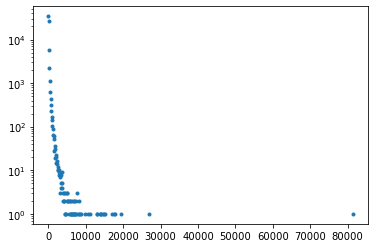

In [29]:
line_string_lengths = []
for feature in xx_jsoned["features"]:
	coords = np.array(feature["geometry"]["coordinates"])
	line_string_lengths.extend(np.linalg.norm(np.diff(coords, axis=0), axis=1)*EARTH_METRES_PER_DEGREE)

lengths = pd.Series(line_string_lengths, name="length")
lengths.round(-2).value_counts().sort_index().plot(style=".", logy=True, logx=False)

In [24]:
(lengths*EARTH_METRES_PER_DEGREE).round(-2)

0          0.0
1          0.0
2        100.0
3          0.0
4          0.0
         ...  
72308    100.0
72309    400.0
72310    100.0
72311      0.0
72312      0.0
Name: length, Length: 72313, dtype: float64

In [44]:
max_segment_lengths = []
for feature in xx_jsoned["features"]:
	coords = np.array(feature["geometry"]["coordinates"])
	max_segment_lengths.append(np.max(np.linalg.norm(np.diff(coords, axis=0), axis=1)*EARTH_METRES_PER_DEGREE))

max_segment_lengths = pd.Series(max_segment_lengths, name="max_segment_length_metres")

max_segment_lengths[max_segment_lengths>5000]

dat = pd.json_normalize(xx_jsoned["features"])
dat = dat.join(max_segment_lengths)


In [43]:
dat[dat["max_segment_length_metres"]>5000].sort_values("max_segment_length_metres", ascending=False).head()

,type,geometry.type,geometry.coordinates,properties.ROAD,properties.START_SLK,properties.END_SLK,properties.CWY,properties.NETWORK_TYPE,properties.START_TRUE_DIST,properties.END_TRUE_DIST,max_segment_length_metres
2744,Feature,LineString,"[[125.404041941098, -30.85847423197356], [125....",605Z020,0.00,80.90,Single,Miscellaneous Road,0.00,80.90,81284.876382
2942,Feature,LineString,"[[125.8829753144484, -25.75216504127684], [125...",612Z003,0.00,159.00,Single,Miscellaneous Road,0.00,159.00,26774.431067
2665,Feature,LineString,"[[120.32325591609577, -30.822188722130647], [1...",602Z111,44.54,98.50,Single,Miscellaneous Road,44.54,98.50,17760.953579
47,Feature,LineString,"[[124.6837987456833, -17.43442013934009], [124...",003Z014,0.00,17.18,Single,Miscellaneous Road,0.00,17.18,17631.581918
2906,Feature,LineString,"[[120.66788599883245, -30.03532363528558], [12...",609Z024,0.00,24.20,Single,Miscellaneous Road,0.00,24.20,14923.629840
